In [2]:
#!pip install gluoncv==0.10.5.post0

In [1]:
import mxnet as mx
from mxnet import image, gluon
from mxnet.gluon.data.vision import transforms
import gluoncv

ctx = mx.cpu(0)

In [3]:
url = 'https://cdn.pixabay.com/photo/2019/05/23/19/29/dog-4224638_1280.jpg'
filename = 'dog.jpg'
gluoncv.utils.download(url, filename, True)

163KB [00:00, 2621.92KB/s]             


'dog.jpg'

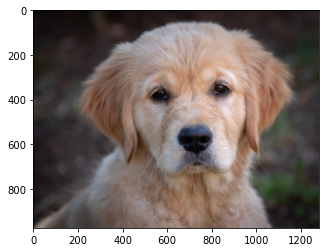

In [4]:
img = image.imread(filename)

from matplotlib import pyplot as plt
plt.imshow(img.asnumpy())
plt.show()

In [5]:
type(img), img.shape

(mxnet.ndarray.ndarray.NDArray, (975, 1280, 3))

In [6]:
from gluoncv.data.transforms.presets.imagenet import transform_eval
img = transform_eval(img)
type(img), img.shape

[2022-10-22 21:27:30.194 ip-172-16-71-104:2946 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-22 21:27:30.219 ip-172-16-71-104:2946 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


(mxnet.ndarray.ndarray.NDArray, (1, 3, 224, 224))

In [7]:
from gluoncv.utils import export_block
net = gluoncv.model_zoo.get_model('resnet18_v1', pretrained=True)
export_block('./model/model', net, preprocess=False, layout='CHW')
print('Done.')

Done.


In [9]:
model = gluon.SymbolBlock.imports(
        "./model/model-symbol.json",
        ["data"],
        "./model/model-0000.params",
        ctx=ctx,
    )

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1454: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [10]:
output = model(img)

In [11]:
from mxnet import nd
classes = net.classes
pred = mx.nd.array(output[0])[None]

topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input picture is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input picture is classified to be
	[golden retriever], with probability 0.983.
	[Labrador retriever], with probability 0.011.
	[Tibetan mastiff], with probability 0.002.
	[kuvasz], with probability 0.001.
	[Great Pyrenees], with probability 0.001.


In [12]:
import boto3, sagemaker

region = "eu-west-1"
sm_client = boto3.client(service_name="sagemaker", region_name=region)
runtime_sm_client = boto3.client("sagemaker-runtime", region_name=region)
session = sagemaker.Session(boto_session=boto3.Session(region_name=region))
role = "arn:aws:iam::257446244580:role/sagemaker-icevision"

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [13]:
default_bucket = session.default_bucket()
print(default_bucket)

sagemaker-eu-west-1-257446244580


In [14]:
import os
import json
import tarfile

def flatten(tarinfo):
    tarinfo.name = os.path.basename(tarinfo.name)
    return tarinfo


tar = tarfile.open("model.tar.gz", "w:gz")
tar.add("model", filter=flatten)
tar.close()

In [15]:
model_uri = session.upload_data(path="./model.tar.gz", key_prefix="neo_mxnet")
print(model_uri)

s3://sagemaker-eu-west-1-257446244580/neo_mxnet/model.tar.gz


In [16]:
from sagemaker.mxnet.model import MXNetModel

estimator = MXNetModel(model_data="s3://sagemaker-eu-west-1-257446244580/neo_mxnet/model.tar.gz", 
                       role="arn:aws:iam::257446244580:role/sagemaker-icevision", 
                       entry_point="serve.py", 
                       framework_version='1.7.0',
                       py_version='py3')

In [17]:
from sagemaker.serializers import NumpySerializer
from sagemaker.deserializers import NumpyDeserializer

mxnet_predictor = estimator.deploy(initial_instance_count=1, 
                                   instance_type='ml.m4.xlarge',
                                   endpoint_name="mxnet-test")

-----!

In [19]:
type(img), img.shape, img.asnumpy().shape, type(img.asnumpy())

(mxnet.ndarray.ndarray.NDArray,
 (1, 3, 224, 224),
 (1, 3, 224, 224),
 numpy.ndarray)

In [20]:
response = mxnet_predictor.predict(img.asnumpy())

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (503) from primary with message "{
  "code": 503,
  "type": "InternalServerException",
  "message": "Prediction failed"
}
". See https://eu-west-1.console.aws.amazon.com/cloudwatch/home?region=eu-west-1#logEventViewer:group=/aws/sagemaker/Endpoints/mxnet-test in account 257446244580 for more information.